# Hierarchical model with common $\sigma^2$

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from scipy.stats import poisson, norm, invgamma

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
RHO = 3
NU  = 4

np.random.seed(111)
THETA  = norm.rvs(size=J, loc=MU, scale=TAU)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

ALPHA_LEVEL = 0.05

VARIABLE = 'Y'

Create the data

In [3]:
Y = norm.rvs(size=N[0], loc=THETA[0], scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, [0]*N[0]]).T)

for j in range(1,J):
    Y = norm.rvs(size=N[j], loc=THETA[j], scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

Calculate the statistics per region

In [4]:
DatRegion = Dat[[VARIABLE, 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion['Theta'] = THETA
DatRegion['Sigma'] = SIGMA

In [5]:
Dat = pd.merge(
    Dat
    , DatRegion[['Region', VARIABLE + 'Mean', VARIABLE + 'Std']]
)

---

In [7]:
with pm.Model() as ModelCommonSigma:
    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', -pm.math.log(Sigma))

    Tau    = pm.HalfFlat('Tau')
    Mu     = pm.Flat('Mu')
    Theta  = pm.Normal('Theta', mu=Mu, sigma=Tau, shape=J)

    Income = pm.Normal('Income', mu=Theta[Dat['Region']], sigma=Sigma, observed=Dat[VARIABLE])

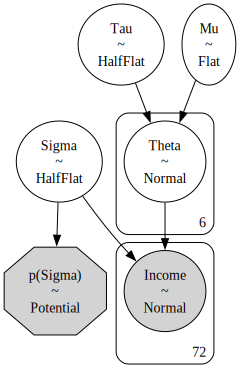

In [8]:
pm.model_to_graphviz(ModelCommonSigma)

---

### Posterior

In [9]:
with ModelCommonSigma:
    TraceCommonSigma = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Tau, Mu, Theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Posterior distribution $p(\\mu|\\mathbf{Y})$')

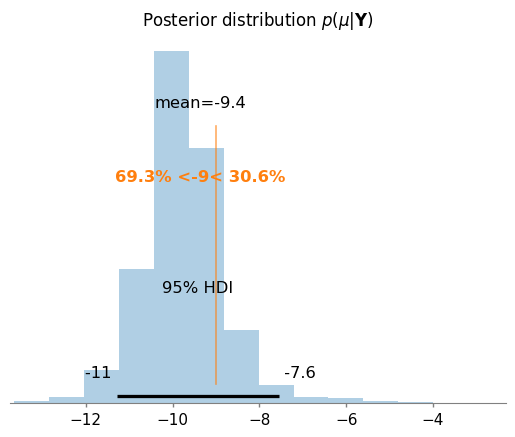

In [13]:
az.plot_posterior(
    TraceCommonSigma
    , var_names = 'Mu'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
    , ref_val = MU
)

plt.title(r"Posterior distribution $p(\mu|\mathbf{Y})$")

Text(0.5, 1.0, 'Posterior distribution $p(\\tau|\\mathbf{Y})$')

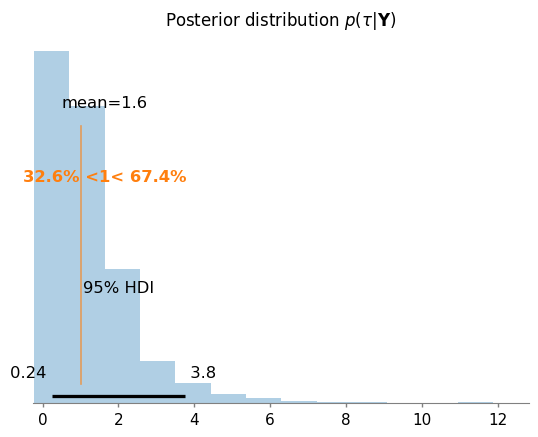

In [14]:
az.plot_posterior(
    TraceCommonSigma
    , var_names = 'Tau'
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize = 11
    , ref_val = TAU
)

plt.title(r"Posterior distribution $p(\tau|\mathbf{Y})$")

In [15]:
PosteriorSigmaSummary = az.summary(TraceCommonSigma, var_names='Sigma', hdi_prob=1-ALPHA_LEVEL, kind='stats')
PosteriorThetaSummary = az.summary(TraceCommonSigma, var_names='Theta', hdi_prob=1-ALPHA_LEVEL, kind='stats')

In [16]:
DatRegion['HatTheta'] = PosteriorThetaSummary['mean'].values
DatRegion['LowTheta'] = PosteriorThetaSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values
DatRegion['UppTheta'] = PosteriorThetaSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values

DatRegion['HatSigma'] = [PosteriorSigmaSummary['mean'].values[0]] * J
DatRegion['LowSigma'] = [PosteriorSigmaSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values[0]] * J
DatRegion['UppSigma'] = [PosteriorSigmaSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values[0]] * J

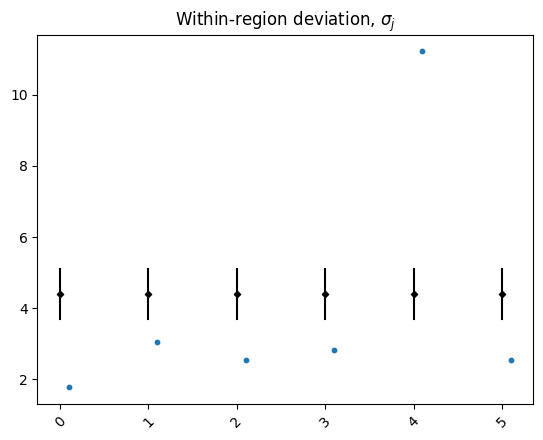

In [17]:
plt.scatter(range(J), DatRegion['HatSigma'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion['Sigma'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowSigma'][j], DatRegion['UppSigma'][j]],
        color='k'
    )

plt.title(r"Within-region deviation, $\sigma_j$")
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

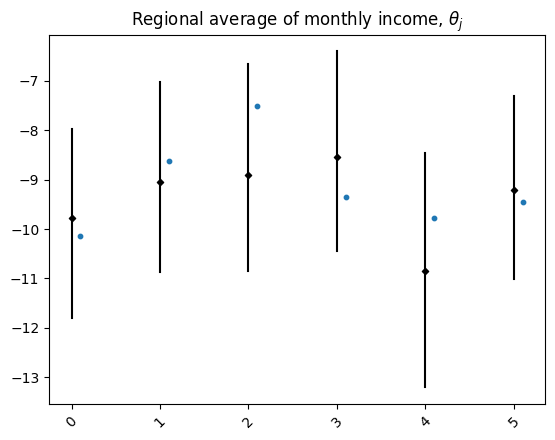

In [18]:
plt.scatter(range(J), DatRegion['HatTheta'], marker='D', color='k', s=10)
plt.scatter(np.arange(0.1, J+0.1, 1), DatRegion['Theta'], marker='o', color='C0', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowTheta'][j], DatRegion['UppTheta'][j]],
        color='k'
    )

plt.title(r'Regional average of monthly income, $\theta_j$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)

---

### Posterior Predictive

In [19]:
with ModelCommonSigma:
    TraceCommonSigma.extend(pm.sample_posterior_predictive(TraceCommonSigma))

Sampling: [Income]


In [20]:
PosteriorPredictiveSummary = az.summary(TraceCommonSigma, group='posterior_predictive', hdi_prob=1-ALPHA_LEVEL, kind='stats')

In [21]:
Dat['HatY'] = PosteriorPredictiveSummary['mean'].values
Dat['LowY'] = PosteriorPredictiveSummary['hdi_' + str((ALPHA_LEVEL/2)*100)  + '%'].values
Dat['UppY'] = PosteriorPredictiveSummary['hdi_' + str((1-ALPHA_LEVEL/2)*100)  + '%'].values

In [22]:
DatRegion = pd.merge(
    DatRegion
    , Dat.iloc[Dat['Region'].drop_duplicates().index][['Region', 'HatY', 'LowY', 'UppY']]
)

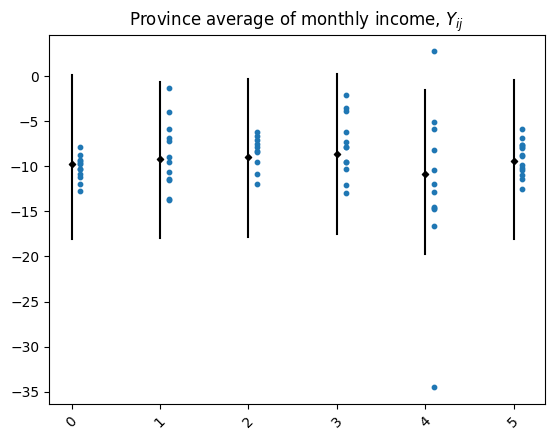

In [23]:
plt.scatter(range(J), DatRegion['HatY'], marker='D', color='k', s=10)

for j in range(J):
    plt.plot(
        [j, j],
        [DatRegion['LowY'][j], DatRegion['UppY'][j]],
        color='k'
    )

    plt.scatter(
        [j+0.1]*DatRegion.loc[DatRegion['Region'] == DatRegion['Region'][j], 'NumberObservations'][j]
        , Dat[Dat['Region'] == DatRegion['Region'][j]][VARIABLE]
        , marker='o'
        , color='C0'
        , s=10
        )

plt.title(r'Province average of monthly income, $Y_{ij}$')
_ = plt.xticks(range(J), labels=DatRegion['Region'], rotation=45)